<a href="https://colab.research.google.com/github/janssonm/Facial-expression-recognition/blob/main/DM1590_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title: DM1590 Final Project: Facial Expression Recognition

## Authors: Lovisa Condé, Andreas Garcia, Matilda Jansson, Ebba Leppänen Gröndal

---

### Background and motivation
The group wanted to work with a machine learning problem with a visual character and thought of Facial Expression Recognition (FER) as an interesting topic. We wanted to look into how facial recognition works and how different methods could be applied to solve the problem. 


### Dataset

The dataset we used consists of 48x48 grayscale images of faces showing the emotions happiness, sadness, surprise, neutral, disgust, fear and anger. The faces in the images were pretty much centered and took up about the same amount of space. The dataset consisted of 35.9k pictures, and the owner's name is Manas Sambare. 

Dataset: https://www.kaggle.com/datasets/msambare/fer2013

### Methodology

First of all, we needed to pre-process the images from the dataset and extract features from them. We decided to extract two types of features, consisting of:
1. Google Mediapipe FaceMesh coordinates (points of interest in the face).
    Mediapipe: https://google.github.io/mediapipe/solutions/face_mesh
2. Pixel intensities (which produces eigenfaces after PCA)

After performing the feature extraction and creating a dataframe, we wanted to reduce the dimensionality of the dataframes by using PCA, which is an unsupervised learning method. We did this both on the FaceMesh coordinates and the pixel intensities. We then used Bisecting KMeans clustering as another unsupervised method to understand the structure and variance in our dataframes.

After that, for our first supervised learning method we used KNN to get an idea of the potential accuracy of the classification. We also fit the KNN classifier to the dataframes (using the best K) and plotted the confusion matrices for the FaceMesh and pixel intensities. We also tried increasing the accuracy of the KNN classifier with the feature selection method SFS. However, because of the low accuracy we finally got from that classifier we decided to try the supervised method RandomForest classifier in order to improve the overall accuracy. Finally, we implemented a real time facial expression predictor through the webcam by using cv2 and mediapipe, together with our RandomForest model.

---

### Imports and relevant functions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#!pip install mediapipe
import mediapipe as mp
import cv2
import os
import time
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
from google.colab import drive
drive.mount('/content/gdrive')
#!pip uninstall scikit-learn -y
#!pip install -U scikit-learn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import BisectingKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 25.4 MB/s eta 0:00:00
Mounted at /content/gdrive
Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 62.5 MB/s eta 0:00:00


In [ ]:
def format_data(dataframe):
  new_array = []
  for i in range(len(dataframe)):
    section = []
    for j in range(478):
      section_stripped = dataframe[i][j].strip("()")
      section_splitted = section_stripped.split(",")
      for val in section_splitted:
        section.append(float(val))
    new_array.append(section)
  
  return new_array

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    """taken from https://gist.github.com/zachguo/10296432"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t\p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()


### Pre-processing

Before creating a dataframe that we can use unsupervised and supervised learning on, we need to convert our image files to matrices and then extract features from them. We will use and compare 2 different methods for the feature selection: 

- Google Mediapipe FaceMesh: In the first method, we use Google's Mediapipe FaceMesh pipeline, which selects the features based on nodes/points of interest in the face. The processing and formatting of the dataset took 25 minutes to compile, where roughly 31700 images of faces were processed. FaceMesh extracted a total of 478 features from the dataset.

- Pixels: This is a more traditional approach to extracting features from images. We simply converted every image in the dataset to matrices, flattened them, and finally received 2304 features from the dataset (which in this case means every pixel intensity of every image)

In [ ]:

def load_images(directory):
  image_list = []
  for image_file in os.listdir(directory):
      img = cv2.imread(os.path.join(directory, image_file))
      if img.any():
          image_list.append(img)
  return image_list

def process_face(img):
  output = []
  with mp_face_mesh.FaceMesh( # From Google Mediapipe
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5) as face_mesh:
    results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    if not results.multi_face_landmarks:
      return # We skip the image if no face landmarks are found in the image
    else:
      for face_landmark in results.multi_face_landmarks[0].landmark: # Only one (first) face
        x = face_landmark.x
        y = face_landmark.y
        z = face_landmark.z
        output.append((x, y, z))
    
  return output

def process_data_to_landmarks(directory):
  processed_images = []
  labels = []
  expressions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
  
  for expression in expressions:
    faces = load_images(directory + expression)
    for face in faces:
        landmarked_image = process_face(face)
        if landmarked_image:
            processed_images.append(landmarked_image)
            labels.append(expression)

  df = pd.DataFrame(processed_images)
  df.index = labels
  df.to_csv('gdrive/My Drive/Colab Notebooks/DM1590/face_expressions_dataset_full.csv')

def process_data_to_pixels(directory):
  processed_images = []
  labels = []
  expressions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
  
  for expression in expressions:
    faces = load_images(directory + expression)
    for face in faces:
      processed_images.append(face.flatten())
      labels.append(expression)

  df = pd.DataFrame(processed_images)
  df.index = labels
  df.to_csv('gdrive/My Drive/Colab Notebooks/DM1590/face_expressions_intensity_dataset_full.csv')

#process_data_to_landmarks("gdrive/My Drive/Colab Notebooks/DM1590/train/")
#process_data_to_pixels("gdrive/My Drive/Colab Notebooks/DM1590/train/")


### Dataframe creation

Here we create our two different dataframes (from the two different feature selections), which will later be used for unsupervised and supervised learning. Note that we (after we did some testing) drop 3 of the facial expressions here (angry, fear, disgust) since they were the most confusing ones. We also reformat the FaceMesh landmark data so that we can conduct the train-test-split on it conveniently.

In [ ]:
facemesh_df = pd.read_csv('gdrive/My Drive/Colab Notebooks/DM1590/face_expressions_dataset_full.csv', index_col=0)
# Dropping unwanted & confusing expressions
facemesh_df = facemesh_df.drop(index="angry")
facemesh_df = facemesh_df.drop(index="fear")
facemesh_df = facemesh_df.drop(index="disgust")
facemesh_labels = facemesh_df.index  
facemesh_data = format_data(facemesh_df.iloc[:,0:].to_numpy()) 

pixel_df = pd.read_csv('gdrive/My Drive/Colab Notebooks/DM1590/face_expressions_intensity_dataset_full.csv', index_col=0)
# Dropping unwanted & confusing expressions
pixel_df = pixel_df.drop(index="angry")
pixel_df = pixel_df.drop(index="fear")
pixel_df = pixel_df.drop(index="disgust")
pixel_labels = pixel_df.index   
pixel_data = pixel_df.iloc[:,0:] 

X_train_facemesh, X_test_facemesh, y_train_facemesh, y_test_facemesh = train_test_split(facemesh_data, facemesh_labels, test_size=0.2)
X_train_pixel, X_test_pixel, y_train_pixel, y_test_pixel = train_test_split(pixel_data, pixel_labels, test_size=0.2)


### PCA

As a part of our initial unsupervised learning, we conducted a PCA on each dataframe (FaceMesh features and pixel intensity features respectively) in order to see how much we can reduce the dimensionality of the dataframes without reducing the explained variances. 
- FaceMesh: We initially had 478 features in our FaceMesh dataframe, but reduced these with PCA to 12 features which were sufficient to describe 100% of the dataset.

- Pixels: We initially had 2304 features in our pixel intensity dataframe, but reduced these with PCA to 100 features (which here becomes our eigenfaces). These 100 eigenfaces however only explained about 60% of the variance in the dataset. 

PCA: FaceMesh

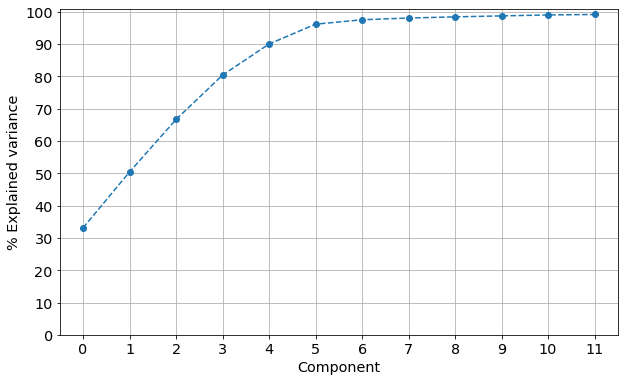

In [ ]:
facemesh_pca = PCA(n_components=12) # 12 components explains practically 100% of the variance
Xprime_train_facemesh = facemesh_pca.fit_transform(X_train_facemesh)  
Xprime_test_facemesh = facemesh_pca.transform(X_test_facemesh)

#filename = 'gdrive/My Drive/Colab Notebooks/DM1590/PCA_facemesh_finish.sav'
#pickle.dump(facemesh_pca, open(filename, 'wb'))

params = {'legend.fontsize': 'x-large','figure.figsize': (10, 6),
         'axes.labelsize': 'x-large','xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(100*np.cumsum(facemesh_pca.explained_variance_ratio_),'o--')  
plt.xlabel('Component'); plt.ylabel('% Explained variance')
plt.xticks(np.arange(0,facemesh_pca.components_.shape[0],1))
plt.yticks(np.arange(0,101,10))
plt.xlim(0-0.5,facemesh_pca.components_.shape[0]-0.5)
plt.ylim(0,101)
ax.grid(); plt.show()

PCA: Pixel intensities

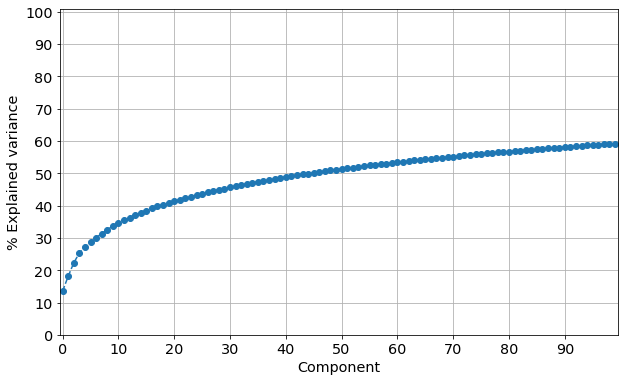

In [ ]:
pixel_pca = PCA(n_components=100, whiten=True) # 100 components (eigenfaces) explains about 60% of the variance
Xprime_train_pixel = pixel_pca.fit_transform(X_train_pixel)
Xprime_test_pixel = pixel_pca.transform(X_test_pixel)

params = {'legend.fontsize': 'x-large','figure.figsize': (10, 6),
         'axes.labelsize': 'x-large','xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(100*np.cumsum(pixel_pca.explained_variance_ratio_),'o--')
plt.xlabel('Component'); plt.ylabel('% Explained variance')
plt.xticks(np.arange(0,pixel_pca.components_.shape[0],10))
plt.yticks(np.arange(0,101,10))
plt.xlim(0-0.5,pixel_pca.components_.shape[0]-0.5)
plt.ylim(0,101)
ax.grid(); plt.show()

Showing eigenfaces from pixel intensity PCA

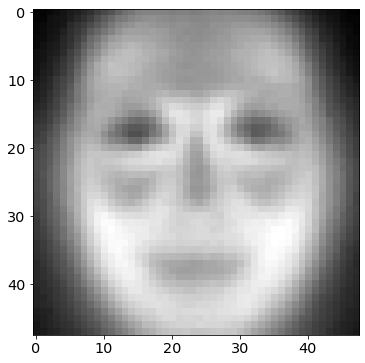

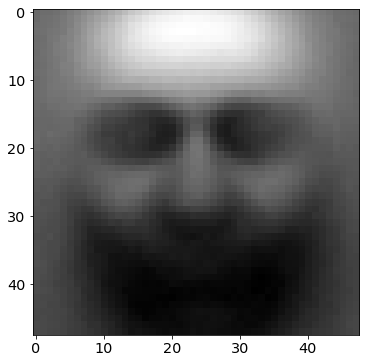

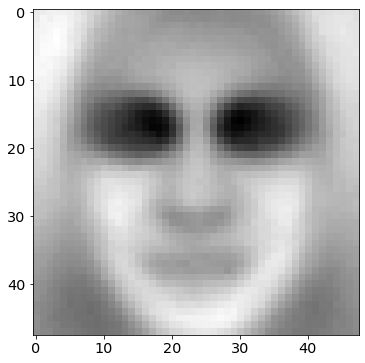

In [ ]:
# Showing some eigenfaces to further see how the PCA worked on the pixel intensity dataframe
plt.imshow(pixel_pca.components_[0].reshape((48, 48)), cmap="gray")
plt.show()
plt.imshow(pixel_pca.components_[3].reshape((48, 48)), cmap="gray")
plt.show()
plt.imshow(pixel_pca.components_[9].reshape((48, 48)), cmap="gray")
plt.show()



### Bisecting KMeans Clustering



As part of our other unsupervised learning, we wanted to test out the BisectingKMeans clustering method in order to understand the structure and variance of our data. BisectingKMeans is a modification of the traditional KMeans method and acts as a hybrid between partitional and hierarchical clustering. We clustered our different training datas (with the amount of PCA components set to 2 since we can visualize 2 dimensions) and the resulting plots provided pretty clear insight as to the patterns in our data (however with the FaceMesh points having significantly more variance than the pixel intensities) and thus the different face expressions, so we decided to move on with both sets of features to the next step.

BKMeans Clustering: FaceMesh

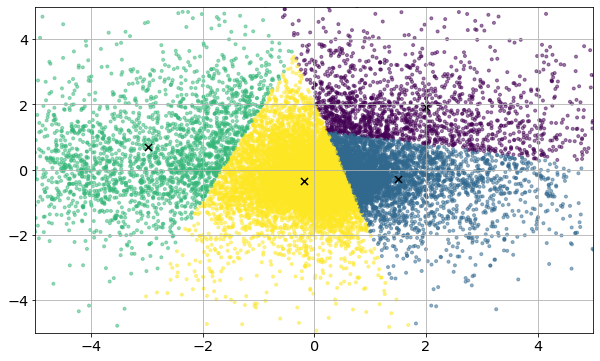

In [ ]:
facemesh_pca_BKMeans = PCA(n_components=2)

Xprime_train_facemesh_BKMeans = facemesh_pca_BKMeans.fit_transform(X_train_facemesh)

K = 4 # Amount of expressions
Xt_facemesh = np.array(Xprime_train_facemesh_BKMeans)

facemesh_BKmeans = BisectingKMeans(n_clusters=K)
facemesh_BKmeans.fit(Xt_facemesh)

plt.scatter(Xt_facemesh[:, 0], Xt_facemesh[:, 1], alpha=0.5, c=facemesh_BKmeans.labels_, marker='.')
plt.xlim(-5, 5); plt.ylim(-5, 5)
plt.scatter(facemesh_BKmeans.cluster_centers_[:, 0], facemesh_BKmeans.cluster_centers_[:, 1], s=50, c='black', marker='x')
plt.grid(); plt.show()

Eigenfaces

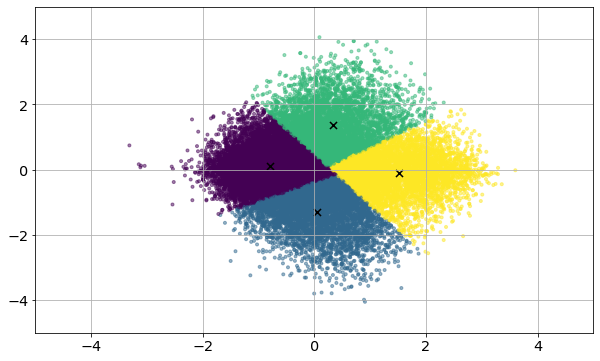

In [ ]:
pixel_pca_BKMeans = PCA(n_components=2, whiten=True)

Xprime_train_pixel_BKMeans = pixel_pca_BKMeans.fit_transform(X_train_pixel)

K = 4 # Amount of expressions
Xt_pixel = np.array(Xprime_train_pixel_BKMeans)

pixel_BKmeans = BisectingKMeans(n_clusters=K)
pixel_BKmeans.fit(Xt_pixel)
plt.scatter(Xt_pixel[:, 0], Xt_pixel[:, 1], alpha=0.5, c=pixel_BKmeans.labels_, marker='.')
plt.xlim(-5, 5); plt.ylim(-5, 5)
plt.scatter(pixel_BKmeans.cluster_centers_[:, 0], pixel_BKmeans.cluster_centers_[:, 1], s=50, c='black', marker='x')
plt.grid(); plt.show()

### KNN 
For the first supervised learning method, we chose the KNN classifier, since it feels like a good starting point to get an idea about the learnability of our dataframes. We started by finding the best K for both the FaceMesh data (after PCA) and the eigenface (pixel intensity - after PCA) data, by plotting the classifier accuracies for both dataframes over different K:s. We then made a decision to only move forward with the features that provided the highest accuracies on the mentioned plots, and this turned out to be the FaceMesh dataframe. Finally, we fit a new KNN model to the FaceMesh data where the best K was used.

**Step 1: Finding the best K**

Finding the best K: FaceMesh

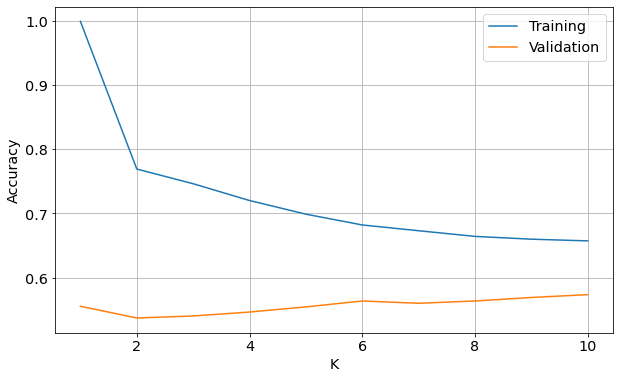

In [ ]:
testaccuracy = []
trainaccuracy = []

k = range(1,11)
for i in k:
  knn_facemesh = KNeighborsClassifier(n_neighbors=i)
  knn_facemesh = knn_facemesh.fit(Xprime_train_facemesh, y_train_facemesh) 
  trainaccuracy.append(knn_facemesh.score(Xprime_train_facemesh, y_train_facemesh)) 
  testaccuracy.append(knn_facemesh.score(Xprime_test_facemesh, y_test_facemesh))


# plotting the training- and validation accuracy of KNN depending on K
fig, ax = plt.subplots()
plt.plot(k, trainaccuracy)
plt.plot(k, testaccuracy)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend(['Training','Validation'])
plt.grid()
plt.show()

Finding the best K: Eigenfaces

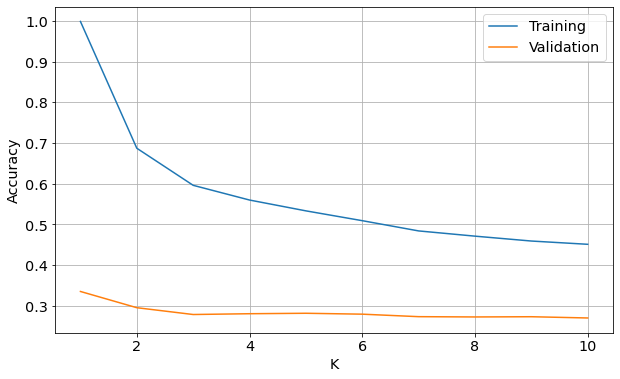

In [ ]:
testaccuracy = []
trainaccuracy = []

k = range(1,11)
for i in k:
  knn_eigenface = KNeighborsClassifier(n_neighbors=i)
  knn_eigenface = knn_eigenface.fit(Xprime_train_pixel, y_train_pixel) 
  trainaccuracy.append(knn_eigenface.score(Xprime_train_pixel, y_train_pixel)) 
  testaccuracy.append(knn_eigenface.score(Xprime_test_pixel, y_test_pixel))


# plotting the training- and validation accuracy of KNN depending on K
fig, ax = plt.subplots()
plt.plot(k, trainaccuracy)
plt.plot(k, testaccuracy)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend(['Training','Validation'])
plt.grid()
plt.show()

**Step 2: Fit the KNN Classifier to the data with the best K**

Note: Since the eigenface features resulted in a significantly lower accuracy than the FaceMesh features, we chose to move on with only the FaceMesh dataframe. We also chose to use a SFS feature selector to see if it could improve the accuracy of our KNN Classifier.

In [ ]:
# Instantiating the classifier
knn_facemesh_finished = KNeighborsClassifier(n_neighbors=10)
sfs = SequentialFeatureSelector(knn_facemesh_finished, n_features_to_select=5) 
sfs.fit(Xprime_train_facemesh, y_train_facemesh)
Xprime_sfs_train_facemesh = sfs.transform(Xprime_train_facemesh)
Xprime_sfs_test_facemesh = sfs.transform(Xprime_test_facemesh)
knn_facemesh_finished.fit(Xprime_sfs_train_facemesh, y_train_facemesh)

# Making predictions and computing confusion matrix
knn_facemesh_finished_predicts = knn_facemesh_finished.predict(Xprime_sfs_test_facemesh)
confusion_matrix_facemesh_knn = confusion_matrix(y_test_facemesh, knn_facemesh_finished_predicts, normalize="true")
print(print_cm(confusion_matrix_facemesh_knn, ["happy", "neutral", "sad", "surprise"]))
print('Accuracy:', accuracy_score(y_test_facemesh, knn_facemesh_finished_predicts))

       t\p      happy  neutral      sad surprise 
       happy     0.84     0.09     0.04     0.03 
     neutral     0.10     0.66     0.19     0.05 
         sad     0.19     0.43     0.32     0.06 
    surprise     0.12     0.15     0.14     0.59 
None
Accuracy: 0.636421052631579


### RandomForest
After evaluating the results from our KNN Classifier, we weren't quite content with the accuracy of the model. Thus, we wanted to try another supervised learning method, namingly the RandomForest Classifier. We fit the 
model to our facemesh dataframe with 100 estimators, which provided a significantly better accuracy than KNN. RandomForest also has a built in feature selection, so SFS is redundant here.

In [ ]:
# Instantiating the classifier
forest_facemesh = RandomForestClassifier(n_estimators=100)
forest_facemesh.fit(Xprime_train_facemesh, y_train_facemesh)

#filename = 'gdrive/My Drive/Colab Notebooks/DM1590/forest_model_finish.sav'
#pickle.dump(forest_facemesh, open(filename, 'wb'))

# Making predictions and computing confusion matrix
forest_facemesh_predict = forest_facemesh.predict(Xprime_test_facemesh)
confusion_matrix_facemesh_forest = confusion_matrix(y_test_facemesh, forest_facemesh_predict, normalize="true")
print(print_cm(confusion_matrix_facemesh_forest, ["happy", "neutral", "sad", "surprise"]))
print('Accuracy:', accuracy_score(y_test_facemesh, forest_facemesh_predict))


       t\p      happy  neutral      sad surprise 
       happy     0.85     0.07     0.06     0.02 
     neutral     0.09     0.69     0.19     0.03 
         sad     0.16     0.35     0.45     0.05 
    surprise     0.09     0.10     0.08     0.72 
None
Accuracy: 0.6972631578947368


### Real time prediction with webcam
In order to make live predictions, we used mediapipe and cv2 to extract the landmarks in real-time and then display the predictions every (approximately) 1 seconds. 

In [ ]:
# Note that this code can only be run locally since Colab does not allow for webcam input through cv2

# Loading local saves of the PCA and RandomForest classifier
forest_facemesh = pickle.load(open("forest_model_finish.sav", 'rb'))
pca_facemesh = pickle.load(open("PCA_facemesh_finish.sav", 'rb'))

# Get the facemesh landmarks from the webcam feed
def getLandmarks(face_landmarks):
    output = []
    for face_landmark in face_landmarks[0].landmark:
        x = face_landmark.x
        y = face_landmark.y
        z = face_landmark.z
        output.extend([x, y, z])
        
    return np.array(output)


# Text formatting for displaying predicted expression
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,500)
fontScale              = 3
fontColor              = (255,255,255)
thickness              = 3
lineType               = 2

def predictData(landmarks): # Predicting the landmarks
    landmarks = pd.DataFrame(landmarks)
    landmarks = landmarks.transpose()
    landmarks_pca = pca_facemesh.transform(landmarks)
    predict = forest_facemesh.predict(landmarks_pca)
    
    return str(predict[0])


# For webcam input, code partly taken and modified from: https://google.github.io/mediapipe/solutions/face_mesh
drawing_spec = mp_drawing.DrawingSpec(thickness=1, color=(118, 19, 254), circle_radius=0)
cap = cv2.VideoCapture(0)
predictions = []
average_prediction = None # We calculate the most frequent prediction every 25 frames (aprx. one second) in order to reduce flimmering and give a more robust prediction

with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as face_mesh:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      continue

    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image)
    landmarks = results.multi_face_landmarks

    # Draw the face mesh annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_face_landmarks:
      for face_landmarks in results.multi_face_landmarks:
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=drawing_spec,
            connection_drawing_spec=drawing_spec)
      predictions.append(predictData(getLandmarks(landmarks)))
      if len(predictions) == 20:
        predictCounts = Counter(predictions)
        average_prediction = predictCounts.most_common(1)[0][0]
        predictions = []
      if average_prediction:
        image = cv2.flip(image, 1)
        cv2.putText(image, average_prediction, (100, 200), font, fontScale, fontColor, thickness, lineType)
        image = cv2.flip(image, 1)

    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Face Mesh', cv2.flip(image, 1))
    if cv2.waitKey(5) & 0xFF == 27:
      break
cap.release()


---
## Discussion

The results of our final model depict an accuracy that is neither perfect nor terrible, which is expected given the immense variance in our dataset and in facial expressions in general. When scrutinizing the results more closely, we can draw some conclusions and also compare them to the results of the "real-world" live testing that we did after finalizing the project. 

Upon analyzing the confusion matrix from our final RandomForest classifier, it is evident that the model performs best on the happy facial expressions, and also relatively well on the surprise and neutral expressions. The model clearly confuses the sad expression the most (confusing it with neutral 35% of the time. As for real world testing with the webcam, the model performs accordingly well on happy (especially when smiling with teeth) and surprise expressions. As for sad and neutral expressions, however, the model frequently confuses neutral expressions with sad expressions, while also frequently identifying sad expressions correctly. The latter mentioned results do not correspond with the confusion matrix, which may depend on several reasons. For happy and surprised expressions, the high accuracy could be explained by the uniqueness of these kinds of expressions, while neutral and sad expressions are quite similar to each other and may be confused even by real people in the real world.

Furthermore, when conducting real-world testing we noticed that the classifier performs differently on different people, often performing better on males and especially white males. We started looking for a bias and errors in the dataset, and even though we only looked through a small percentage of the roughly 36 000 total pictures, the dataset actually seemed to be quite diverse in ethnicity and gender. We did however notice that the were not a lot of pictures of individuals with glasses, which may indicate a small bias. We also noticed some errors in the dataset, where e.g. obvious happy expressions were placed in the neutral expressions folder. A lot of the facial expressions also have a lot of variance within themselves, and the perception of these are largly subjective. One's definition of a neutral face might be another person's definition of a sad or happy face.

To continue to improve on the accuracy of the model, a cleaning of the dataset might be beneficial, however that might possibly lead to overfitting the model towards what we subjectively believe defines different expressions, which might not represent the full truth. We could also try to work with other classifiers, such as deep neural networks. That would however require a completely different feature extraction and processing which is not directly comparable to our other methods, which is why we did not implement such a classifier in this project. 

## Acknowledgments

The team worked in parallel on different problems at the same time, but we all made sure to understand each other's parts so that every group member understood the full solution.

## Final meme

Include here a meme describing your experience in this module.

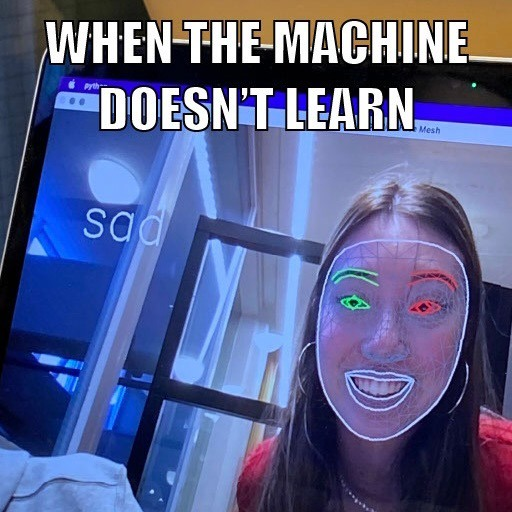

In [ ]:
from IPython import display
display.Image("gdrive/My Drive/Colab Notebooks/DM1590/lovisamaskin.jpg")